# Model objects and predicting whole brain activity

Model objects are superEEG's class that contains the model that reconstructs full brain activity timeseries from a smaller sample of electrodes. The superEEG package offers a few premade models that you can use to reconstruct brain activity, but also a way to create your own model if you have a dataset of intracranial patient data converted into the brain object format.  This tutorial will go over how to use the premade models included in this package, as well as make a new model from scratch.

# Load in the required libraries

In [53]:
import superEEG as se
import seaborn as sns
from nilearn import plotting
from nilearn import image
from scipy import spatial
from scipy.stats import pearsonr, zscore
import pandas as pd
import numpy as np

First, let's load in one of the default models.  Below is a model that we made from the pyFR dataset sampled at 20mm resolution.  The 'k10' means that electrodes with a threshold exceeding 10 were removed from the dataset, and 'r20' means that the model uses a radial basis function of with a width of 20 mm to 'fill in' nearby electrode sites during the model creation.

In [2]:
model = se.load('pyFR_k10r20_20mm')
model.info()

Number of locations: 170
Number of subjects: 67
Date created: Wed Aug 30 14:24:03 2017
Meta data: None


In [3]:
model = se.load('example_model')
model.info()

Number of locations: 170
Number of subjects: 67
Date created: Tue Aug 29 21:35:09 2017
Meta data: None


## Visualizing the model

The model is comprised of a number of fields.  The most important are the `model.numerator` and `model.denominator`.  Dividing these two fields gives a matrix of z-values, where the value in each cell represents the covariance between every model brain location with every other model brain location. To view the model, simply call the `model.plot` method.  This method wraps `seaborn.heatmap` to plot the model (transformed from z to r), so any arguments that `seaborn.heatmap` accepts are supported by `model.plot`.

/Users/lucyowen/repos/superEEG/superEEG/model.py:333: RuntimeWarning: invalid value encountered in divide
  sns.heatmap(z2r(np.divide(self.numerator, self.denominator)), **kwargs)


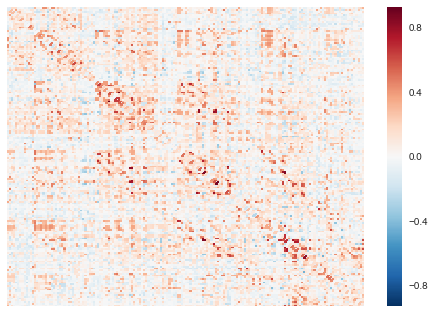

In [4]:
model.plot(xticklabels=False, yticklabels=False)

## Updating the model

Now, let's say we wanted to update the model with a new subjects data.  To do this, we can use the `update` method, passing a new subjects data as a brain object. First, let's load in an example subjects data:

In [67]:
bo = se.load('example_data')
bo.info()
bo.sample_rate

Number of electrodes: 64
Recording time in seconds: [[19 19 19]]
Number of sessions: 1
Date created: Wed Aug 30 15:04:53 2017
Meta data: CH003


[array([[256, 256, 256]], dtype=uint16)]

and then update the model:

In [6]:
updated_model = model.update(bo)
updated_model.info()

/Users/lucyowen/repos/superEEG/superEEG/_helpers/stats.py:141: RuntimeWarning: divide by zero encountered in log
  return 0.5 * (np.log(1 + r) - np.log(1 - r))
/Users/lucyowen/repos/superEEG/superEEG/_helpers/stats.py:122: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(2 * z) - 1) / (np.exp(2 * z) + 1)


Number of locations: 170
Number of subjects: 68
Date created: Wed Aug 30 14:24:10 2017
Meta data: None


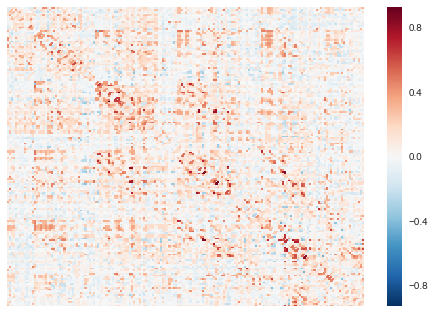

In [7]:
updated_model.plot(xticklabels=False, yticklabels=False)

Note that the model is now comprised of 68 subjects, instead of 67 before we updated it.

## Creating a new model

In addition to including a few premade models in the `superEEG` package, we also provide a way to construct a model from scratch.  For example, if you have a dataset of iEEG patients, we provide a way to construct a model that will predict whole brain activity.  The more subjects you include in the model, the better it will be! To create a model, first you'll need to format your subject data into brain objects.  For the purpose of demonstration, we will simulate 10 subjects and construct the model from that data:

In [8]:
n_subs = 10
bos = [se.simulate_bo(sample_rate=1000) for i in range(n_subs)]
bos[0].info()

Number of electrodes: 10
Recording time in seconds: 1
Number of sessions: 1
Date created: Wed Aug 30 14:24:12 2017
Meta data: None


As you can see above, each simulated subject has 10 (randomly placed) 'electrodes', with 1 second of data each. To construct a model from these brain objects, simply pass them to the `se.Model` class, and a new model will be generated:

The package also includes a method of filtering subjects based on preprocessing threshold.  The default is to remove electrodes that exceed a kurtosis threshold of 10. `se.filter_subj` allows you to compile a list of brain objects in which at least 2 electrodes pass this preprocessing step.  

In [9]:
model_data =[]
for b in bos:
    model_data.append(se.filter_subj(b))

In [10]:
new_model = se.Model(bos)
new_model.info()

/Library/Python/2.7/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/lucyowen/repos/superEEG/superEEG/brain.py:111: UserWarning: No sample rate given.  Setting sample rate to 1000
  warnings.warn('No sample rate given.  Setting sample rate to 1000')


Number of locations: 170
Number of subjects: 10
Date created: Wed Aug 30 14:24:19 2017
Meta data: None


By default, the model is in MNI coordinates with 20mm resolution, but can easily be switched to a different space using some templates we include in the package (Xmm, 8mm, 20mm), or your own custom space (note: the model space MUST be in MNI coordinates).

In [11]:
# new_model = se.Model(bos, template='/your/custom/MNI_template.nii')
# new_model.info()

You can also pass a list (or numpy array) of custom MNI locations to predict:

In [12]:
new_model = se.Model(bos, locs=[[0,0,0],[0,0,1]])
new_model.info()

Number of locations: 2
Number of subjects: 10
Date created: Wed Aug 30 14:24:22 2017
Meta data: None


## Predicting whole brain activity

Now for the magic. `superEEG` uses **_gaussian process regression_** to infer whole brain activity given a smaller sampling of electrode recordings. To predict activity, simply call the `predict` method of a model and pass the subjects brain activity that you'd like to reconstruct:

In [13]:
bo_f = se.filter_elecs(bo, measure='kurtosis', threshold=10)
bo_f.locs.shape
# bo_f.to_nii()

### this is an issue - can't make a nii from a kurtosis filtered brain object

(64, 3)

BEFORE
------
Number of electrodes: 64
Recording time in seconds: [[19 19 19]]
Number of sessions: 1
Date created: Wed Aug 30 14:24:08 2017
Meta data: CH003


/Library/Python/2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Library/Python/2.7/site-packages/nilearn/plotting/glass_brain.py:164: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  black_bg = colors.colorConverter.to_rgba(ax.get_axis_bgcolor()) \


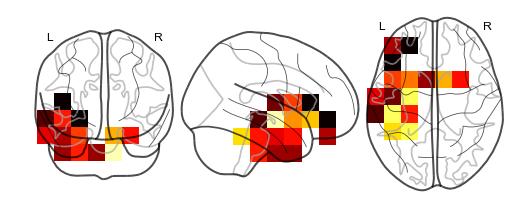

/Users/lucyowen/repos/superEEG/superEEG/model.py:201: RuntimeWarning: invalid value encountered in divide
  model_corrmat_x = np.divide(np.nansum(np.dstack((self.numerator, num_corrmat_x)), 2), self.denominator + denom_corrmat_x)
/Users/lucyowen/repos/superEEG/superEEG/model.py:226: RuntimeWarning: invalid value encountered in divide
  model_corrmat_x = np.divide(num_corrmat_x, denom_corrmat_x)


AFTER
------
Number of electrodes: 170
Recording time in seconds: [[19 19 19]]
Number of sessions: 1
Date created: Wed Aug 30 14:24:55 2017
Meta data: None


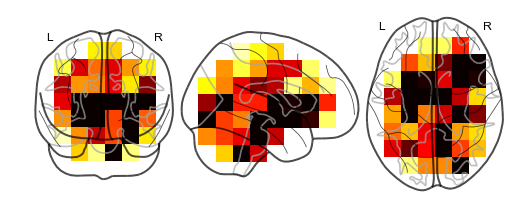

In [14]:
# plot a slice of the original data
print('BEFORE')
print('------')
bo.info()
nii = bo.to_nii()
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0)
plotting.show()

# voodoo magic
bor = model.predict(bo)

# plot a slice of the whole brain data
print('AFTER')
print('------')
bor.info()
nii = bor.to_nii()
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0)
plotting.show()

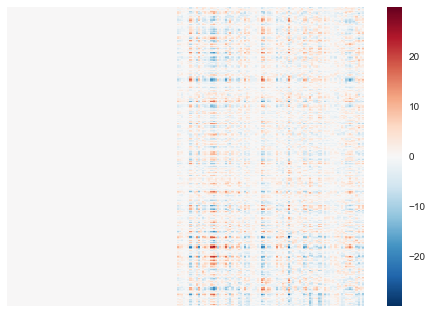

In [64]:
np.where(bor.get_locs()[:, 0] <0)

bor.data.loc[:, bor.get_locs()[:, 0]<0]=0
sns.heatmap(bor.get_data(), yticklabels=False, xticklabels=False)


In [69]:
print('left half zero')
print('------')
bor.info()
nii = bor.to_nii('half_left')
# nii_0 = image.index_img(nii, 1)
# plotting.plot_glass_brain(nii_0)
# plotting.show()

left half zero
------
Number of electrodes: 170
Recording time in seconds: [[19 19 19]]
Number of sessions: 1
Date created: Wed Aug 30 14:24:55 2017
Meta data: None


In [ ]:
nii_0 = image.index_img(nii, 1)
plotting.plot_glass_brain(nii_0)
plotting.show()

Using the `superEEG` algorithm, we've 'reconstructed' whole brain activity from a smaller sample of electrodes. 

To compare the activity of each electrode with its nearest neighbor.

In [15]:
tree = spatial.KDTree(bor.locs)

In [46]:
lst = []
for l in range(bo.locs.shape[0]):
    lst.append([tree.query(bo.get_locs()[l])[0], pearsonr(bor.get_data()[:, tree.query(bo.get_locs()[l])[1]], bo.get_zscore_data()[:, l])[0]])
#     lst.append([bo.get_locs()[l], tree.query(bo.get_locs()[l])[0], pearsonr(bor.get_data()[:, tree.query(bo.get_locs()[l])[1]], bo.get_zscore_data()[:, l])[0]])
    
df = pd.DataFrame(lst, columns = {'distance', 'correlation'})

In [17]:
# bor.get_locs()[:, 0] = bor.get_locs()[:, 0] * -1

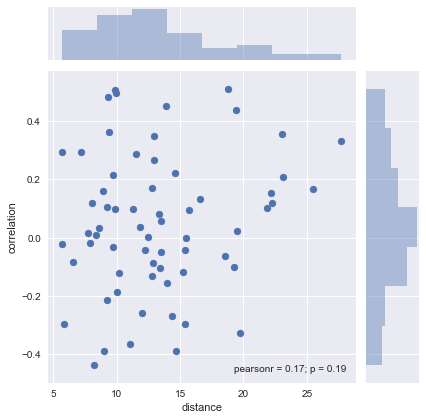

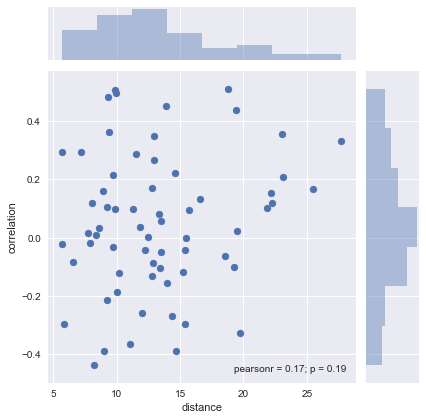

In [50]:
sns.jointplot(data = df, x = 'distance', y = 'correlation')
sns.plt.show()

In [19]:
# for l in range(bo.locs.shape[0]):
#     print bo.get_locs()[l], pearsonr(bor.get_data()[:, tree.query(bo.get_locs()[l])[1]], bo.get_zscore_data()[:, l])[0]
    

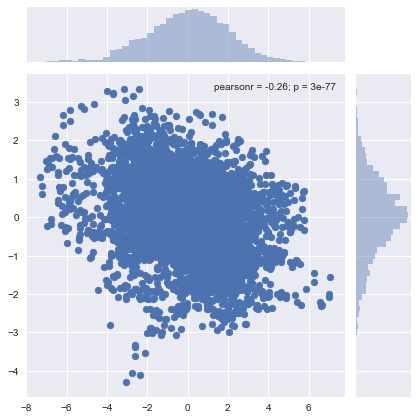

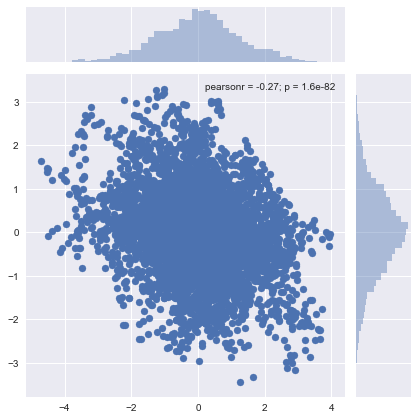

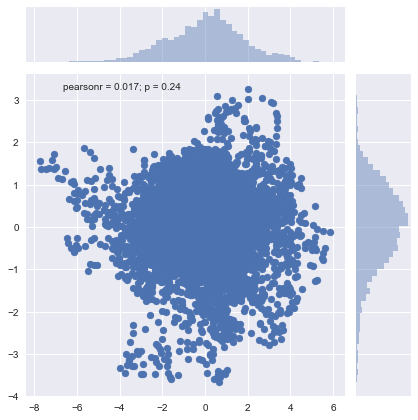

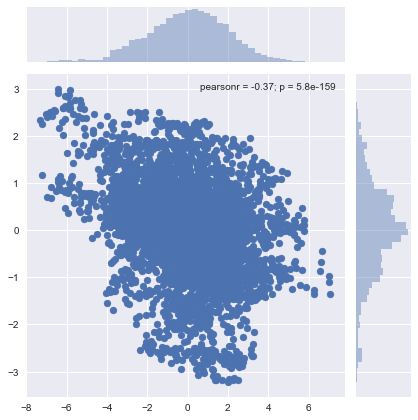

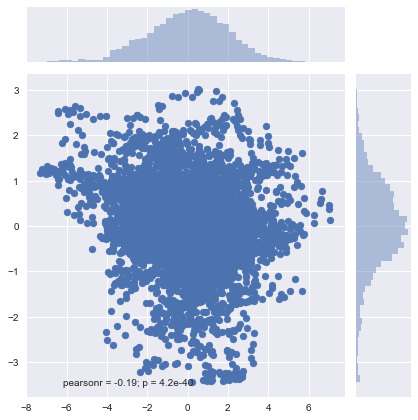

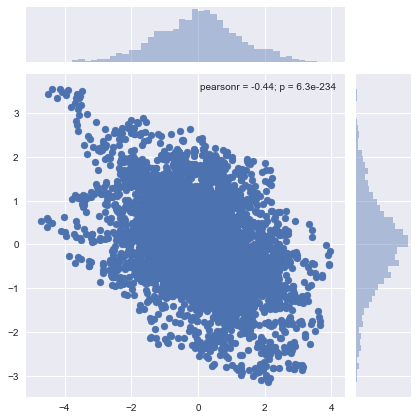

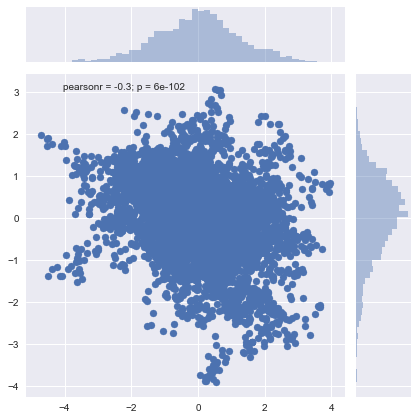

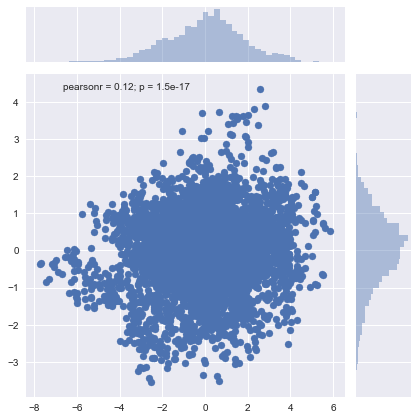

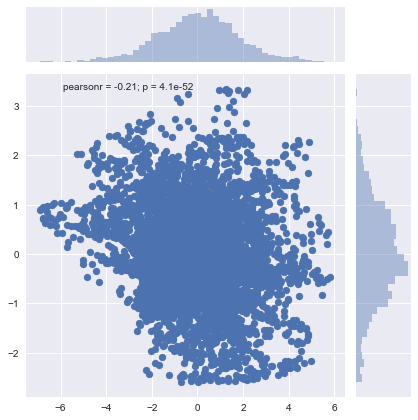

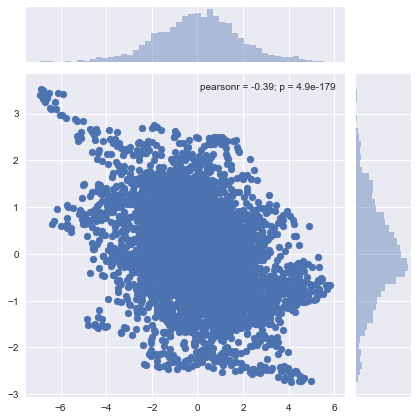

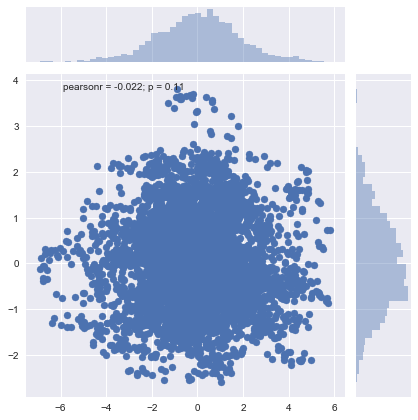

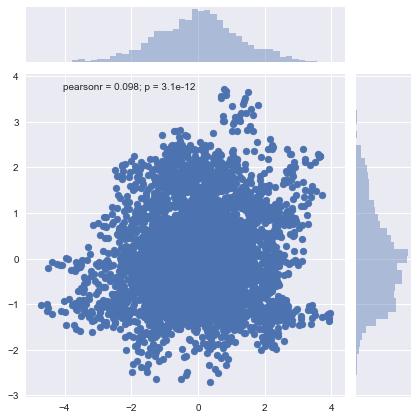

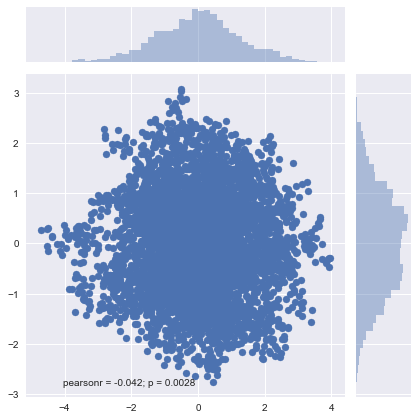

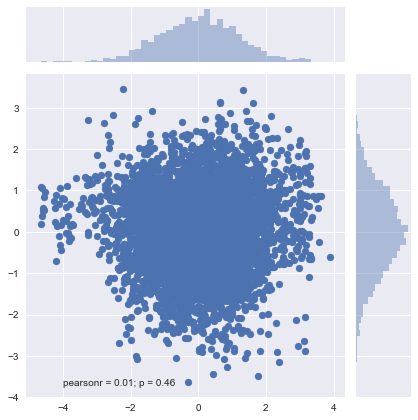

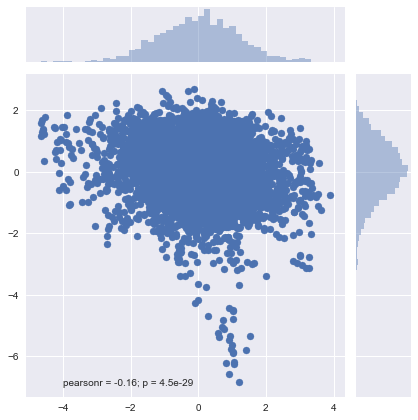

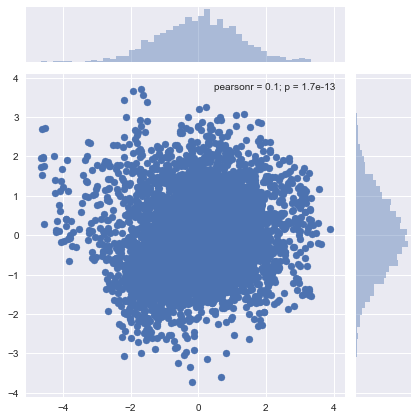

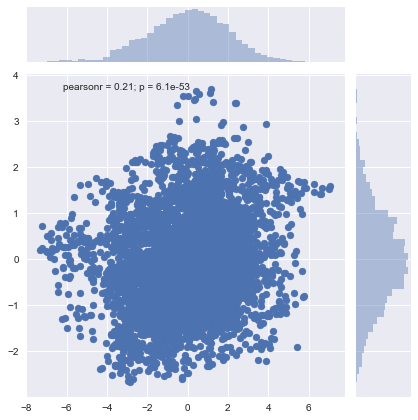

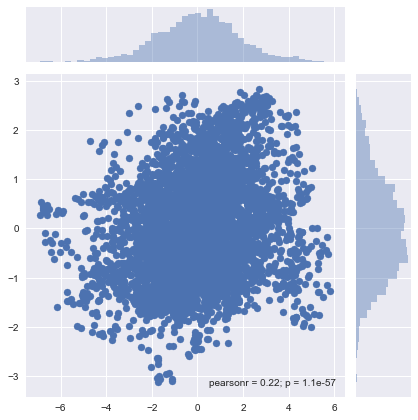

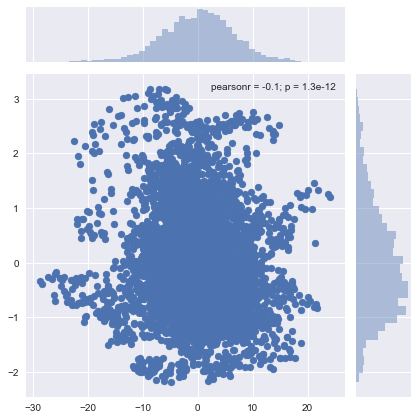

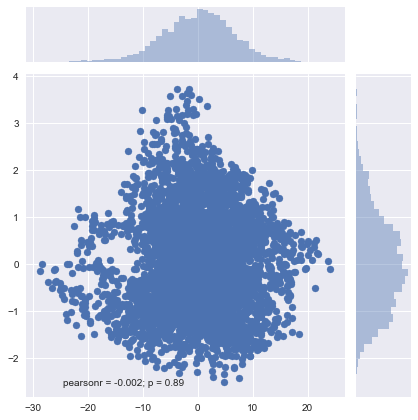

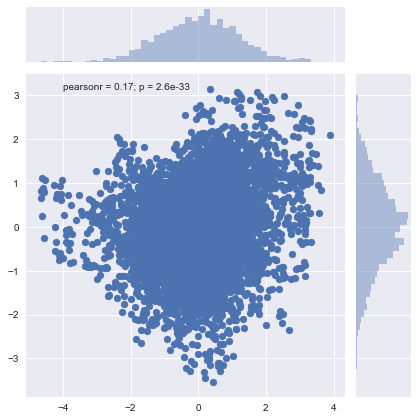

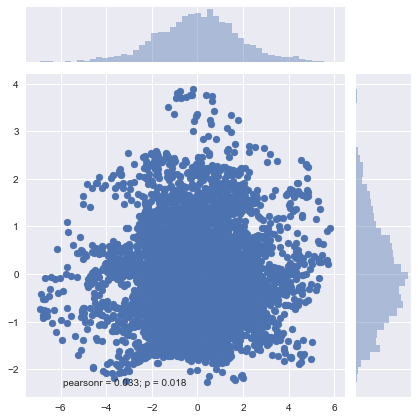

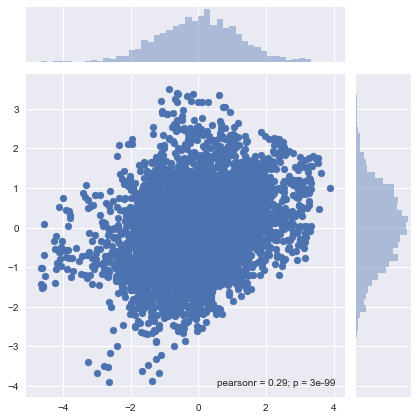

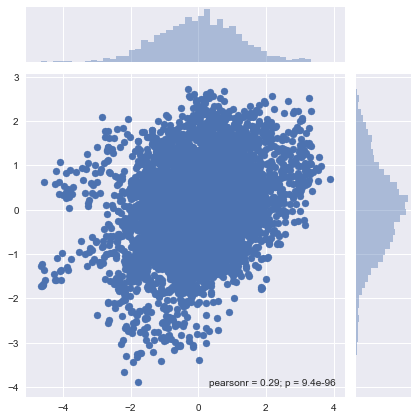

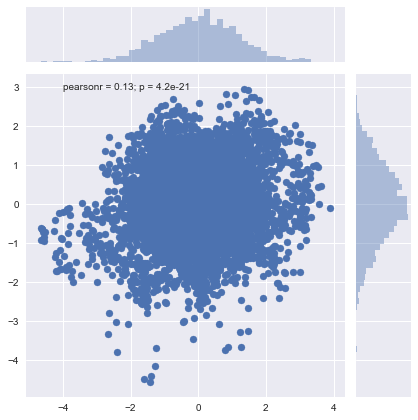

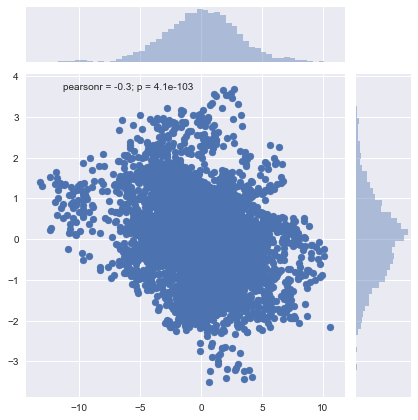

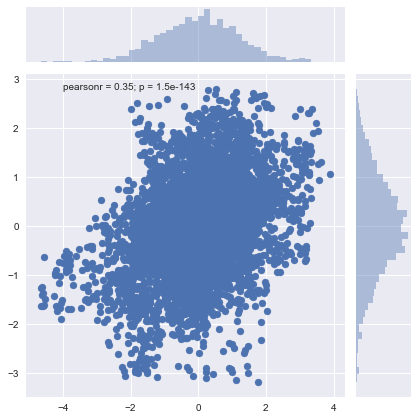

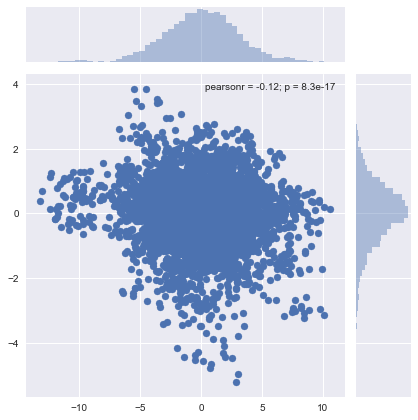

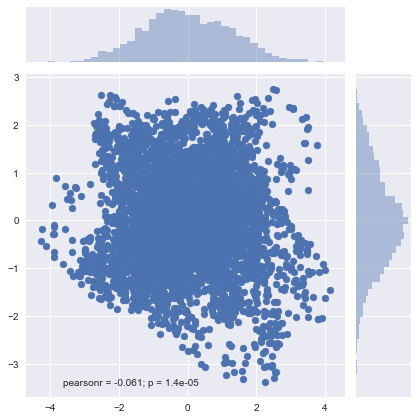

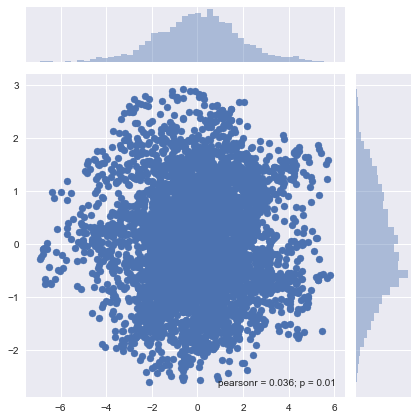

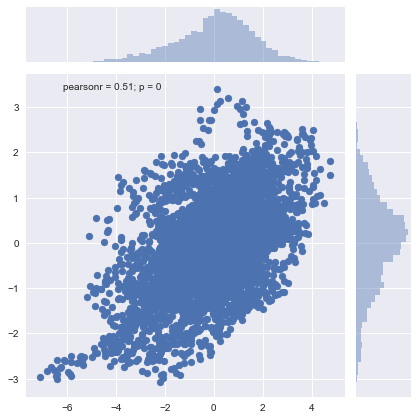

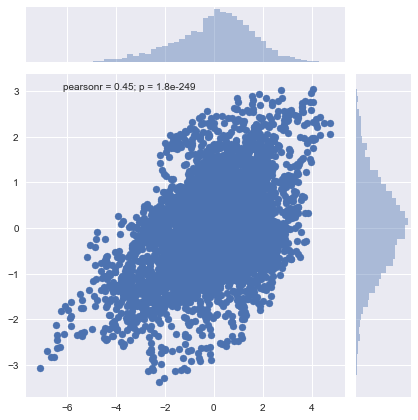

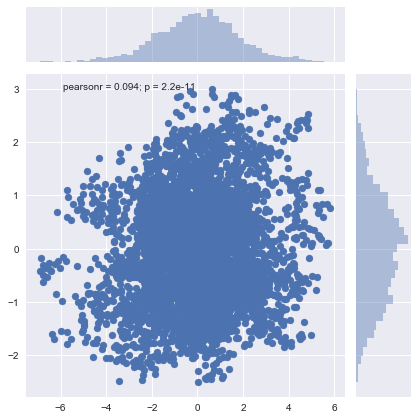

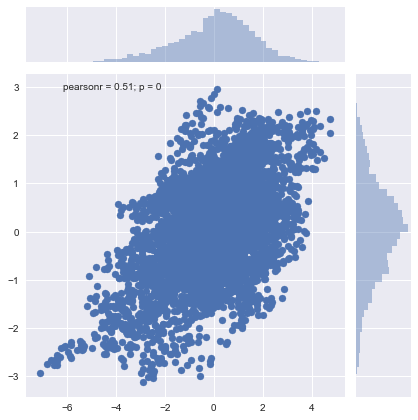

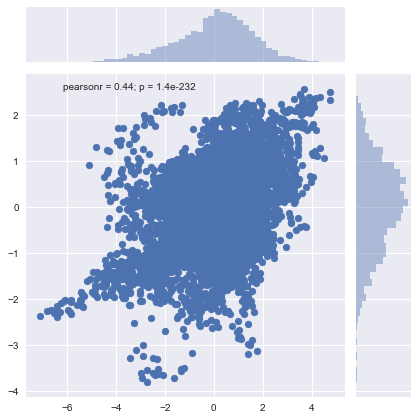

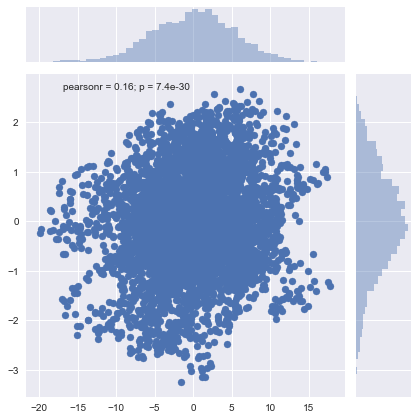

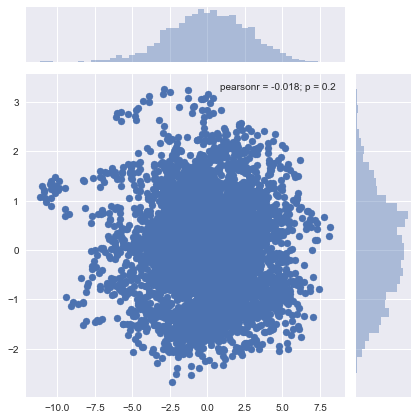

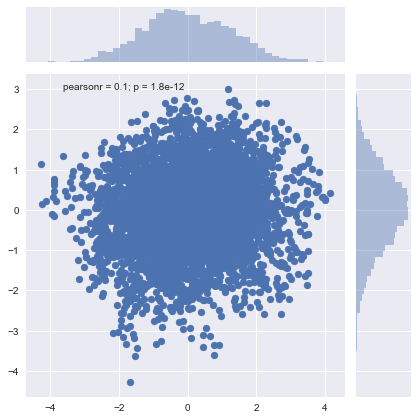

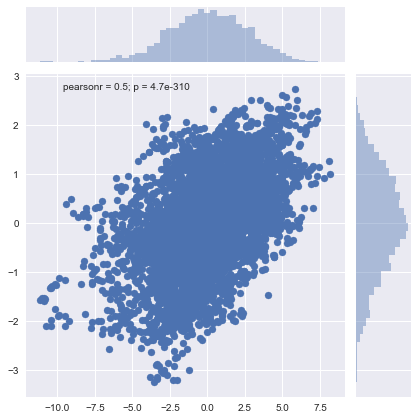

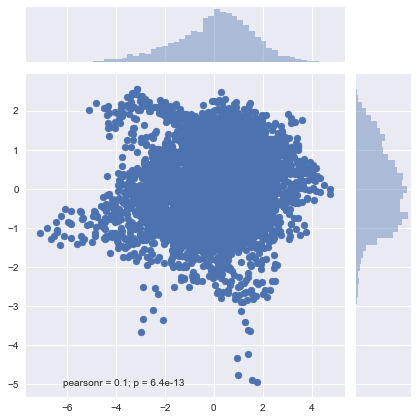

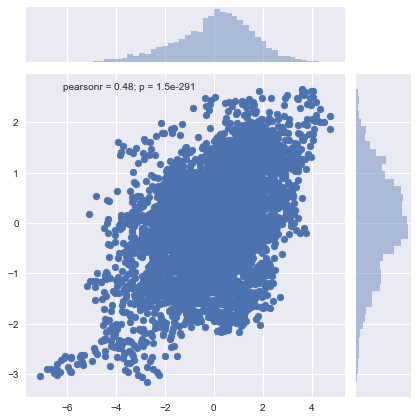

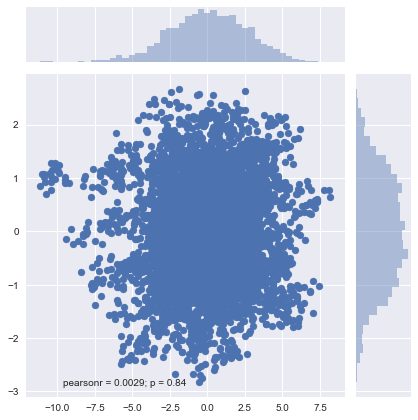

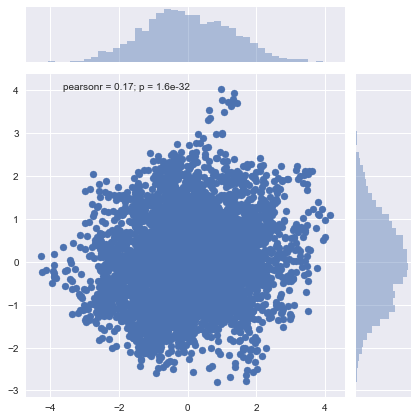

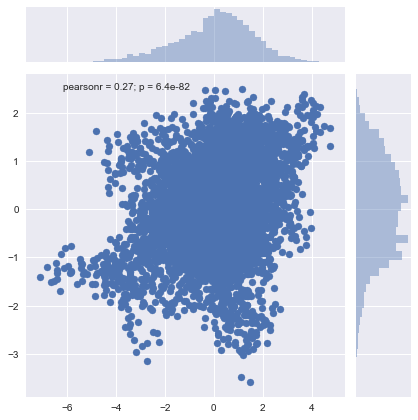

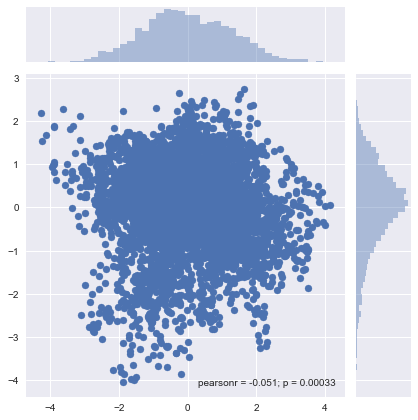

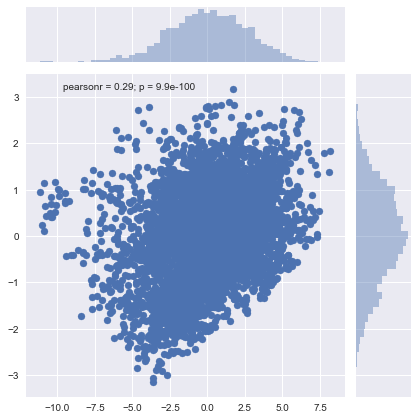

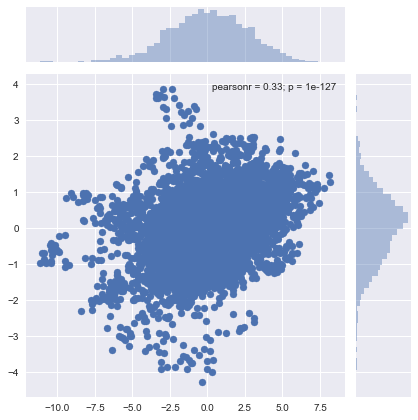

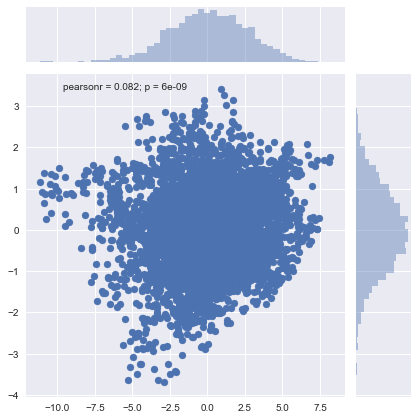

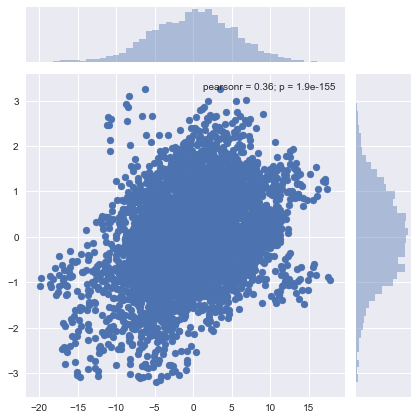

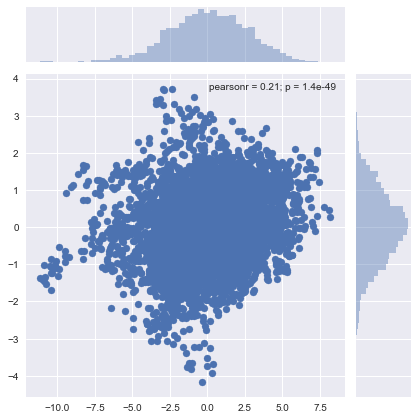

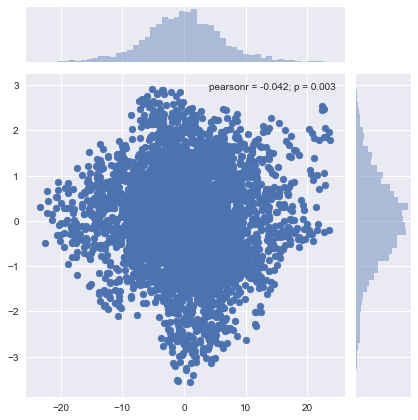

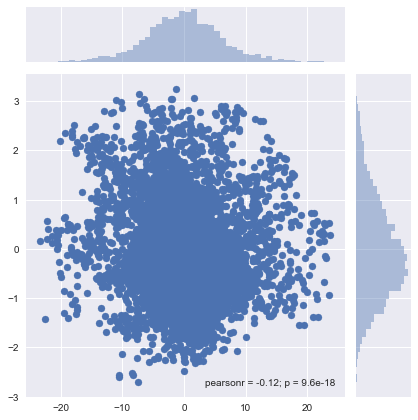

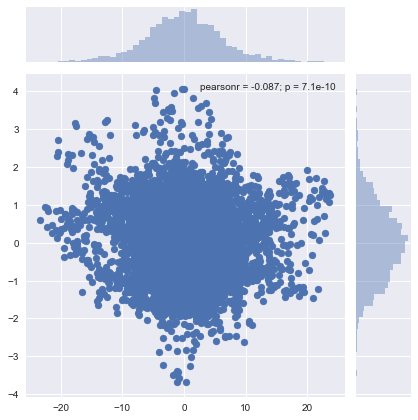

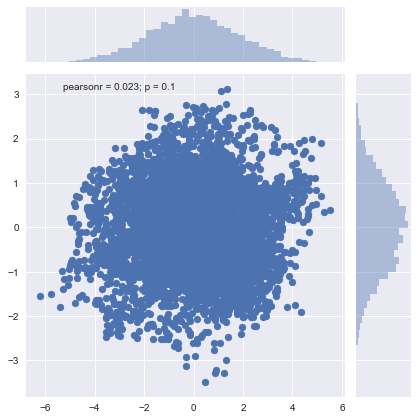

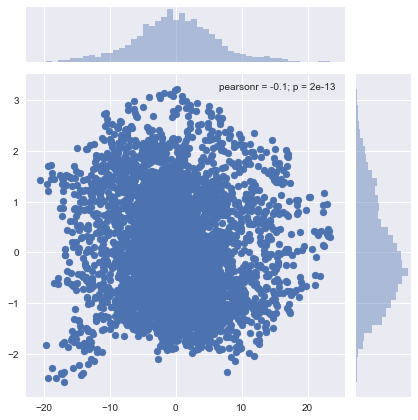

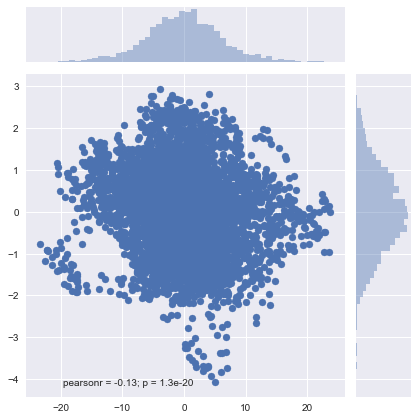

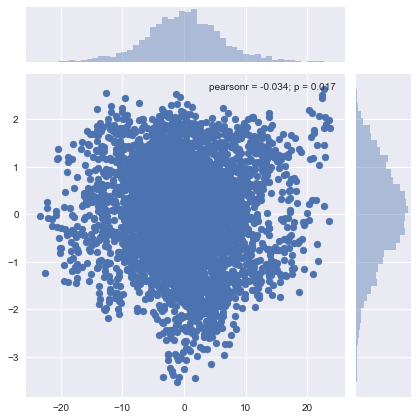

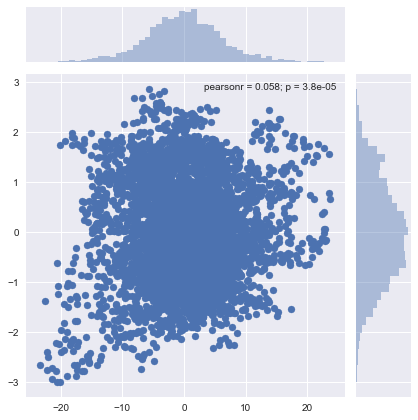

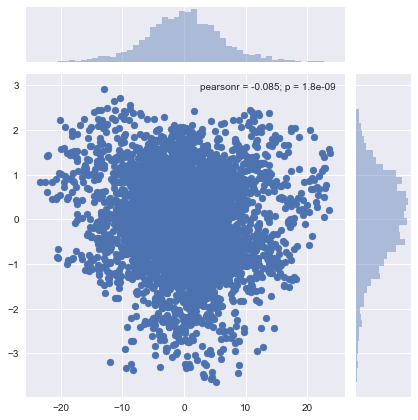

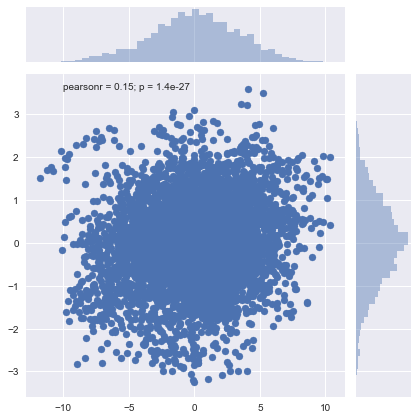

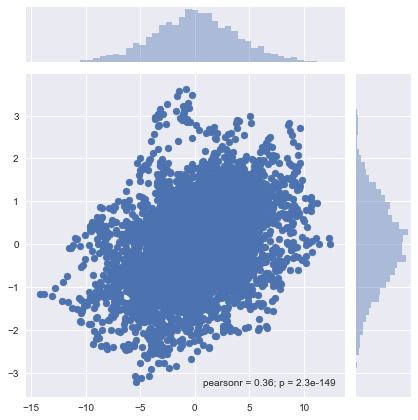

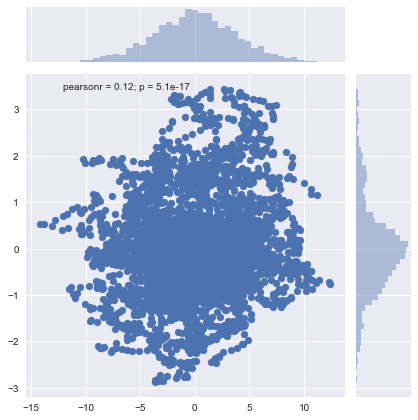

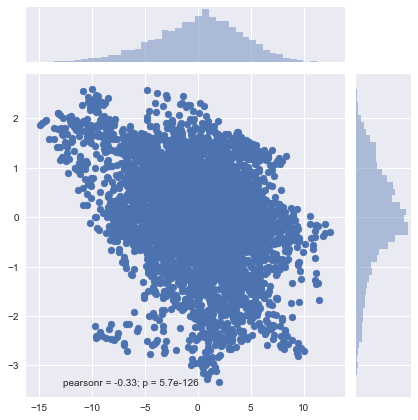

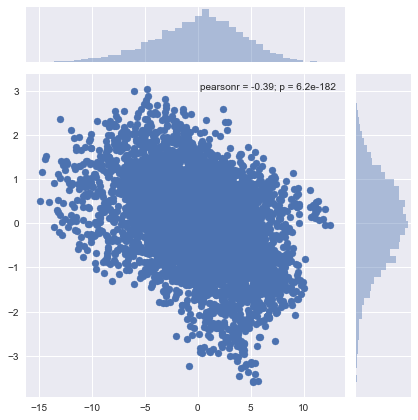

In [30]:
for l in range(bo.locs.shape[0]):
    sns.jointplot(bor.get_data()[:, tree.query(bo.get_locs()[l])[1]], bo.get_zscore_data()[:, l])
    sns.plt.show()

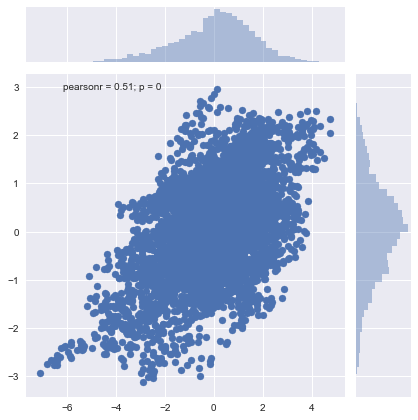

In [27]:
sns.plt.show()